In [1]:
import pandas as pd

In [2]:
import tensorflow as tf
print(tf.__version__)

2.19.0


## Loading the Data

In [3]:
url1 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url2 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url3 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

covid_confirmed = pd.read_csv(url1)
covid_death = pd.read_csv(url2)
covid_recovered = pd.read_csv(url3)

print(covid_death.head())

  Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  2/28/23  3/1/23  3/2/23  3/3/23  \
0        0        0        0        0  ...     7896    7896    7896    7896   
1        0        0        0        0  ...     3598    3598    3598    3598   
2        0        0        0        0  ...     6881    6881    6881    6881   
3        0        0        0        0  ...      165     165     165     165   
4        0        0        0        0  ...     1933    1933    1933    1933   

   3/4/23  3/5/23  3/6/23  3/7/23  3/8/23  3/9/23  
0    7896    7896    7896   

In [6]:
covid_confirmed_aug = covid_confirmed.set_index("Country/Region").drop(columns=['Province/State'])
covid_death_aug = covid_death.set_index("Country/Region").drop(columns=['Province/State'])
covid_recovered_aug = covid_recovered.set_index("Country/Region").drop(columns=['Province/State'])



#### Very few null entries, whereas there are a lot of columns for each day
Lets zoom in on a country in particular, the US

In [7]:
us_confirmed = covid_confirmed_aug.loc[['US']]
us_confirmed

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
Country/Region,,,,,,,,,,,,,,,,,,,,,
US,40.0,-100.0,1,1,2,2,5,5,5,6,...,103443455,103533872,103589757,103648690,103650837,103646975,103655539,103690910,103755771,103802702


C:\Users\ragha\AppData\Local\Temp\ipykernel_10080\465748653.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  us_cases.index = pd.to_datetime(us_cases.index)  # convert string dates to datetime


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

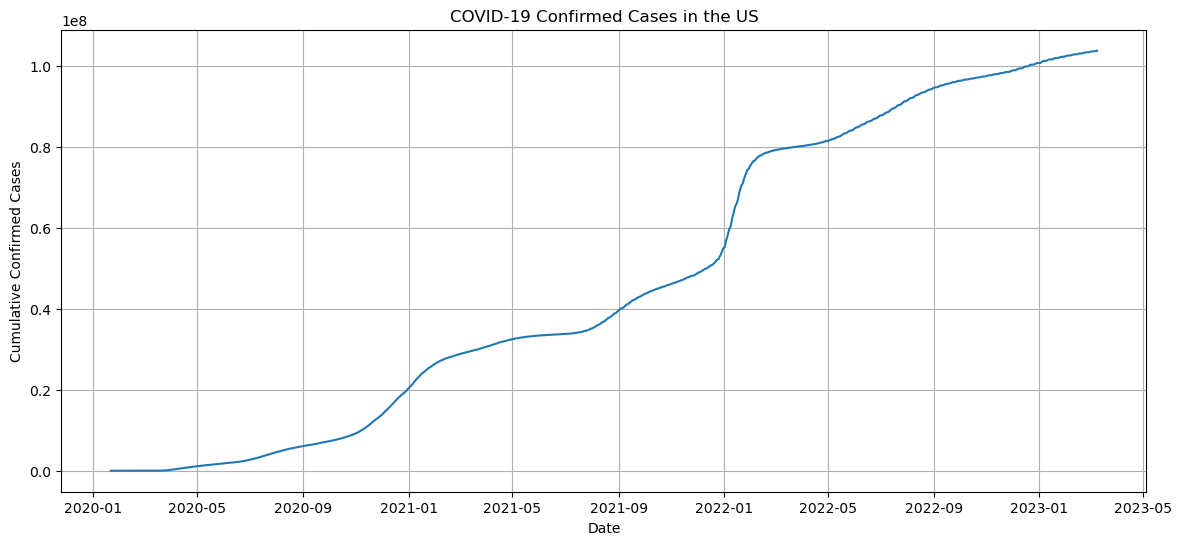

In [8]:
import matplotlib.pyplot as plt

# Transpose so dates become the index
us_cases = us_confirmed.squeeze().drop(['Lat', 'Long'])  # remove Lat/Long
us_cases.index = pd.to_datetime(us_cases.index)  # convert string dates to datetime

# Plot
plt.figure(figsize=(14,6))
plt.plot(us_cases.index, us_cases.values)
plt.title("COVID-19 Confirmed Cases in the US")
plt.xlabel("Date")
plt.ylabel("Cumulative Confirmed Cases")
plt.grid(True)
plt.tight_layout